# Take Home Data Analysis Assignment

> Raghuram Chowdary Yarragunta<br>
> raghuram.c@mymailworks.com<br>
> 804-610-8322

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
products = pd.read_csv("data/PRODUCTS_TAKEHOME.csv")
transactions = pd.read_csv("data/TRANSACTION_TAKEHOME.csv")
users = pd.read_csv("data/USER_TAKEHOME.csv")

In [4]:
# Identify Nulls in each data set

p_null_counts = products.isnull().sum()
u_null_counts = users.isnull().sum()
t_null_counts = transactions.isnull().sum()

# print(p_null_counts, u_null_counts, t_null_counts, sep='\n')



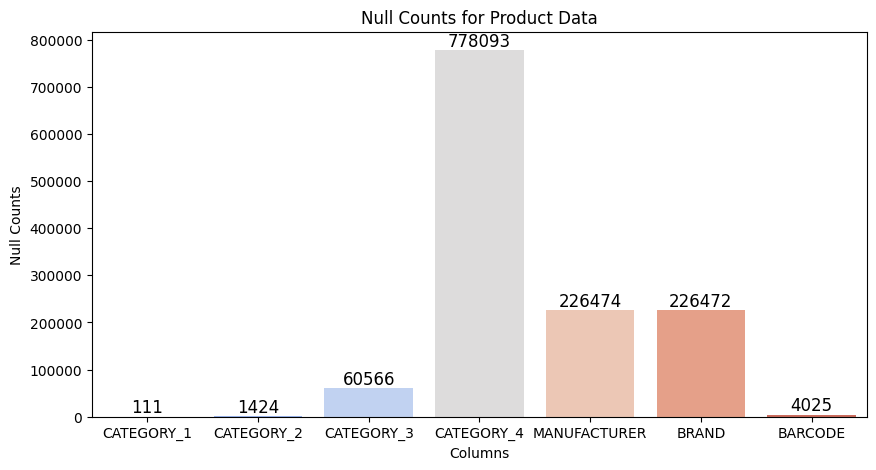

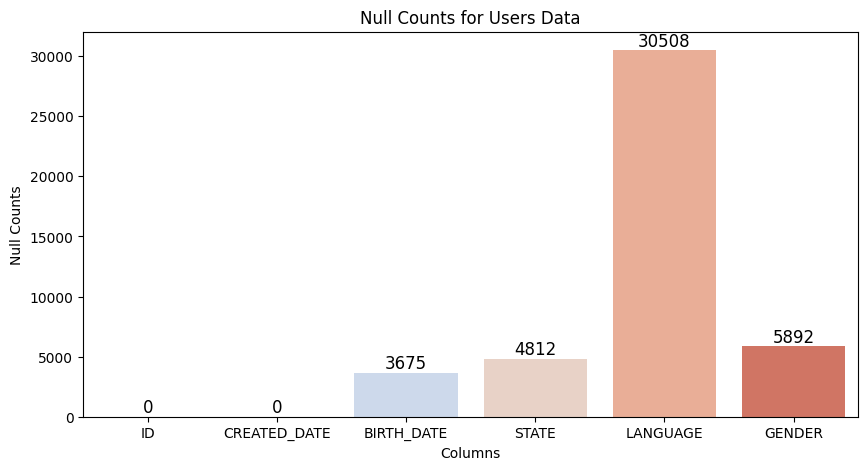

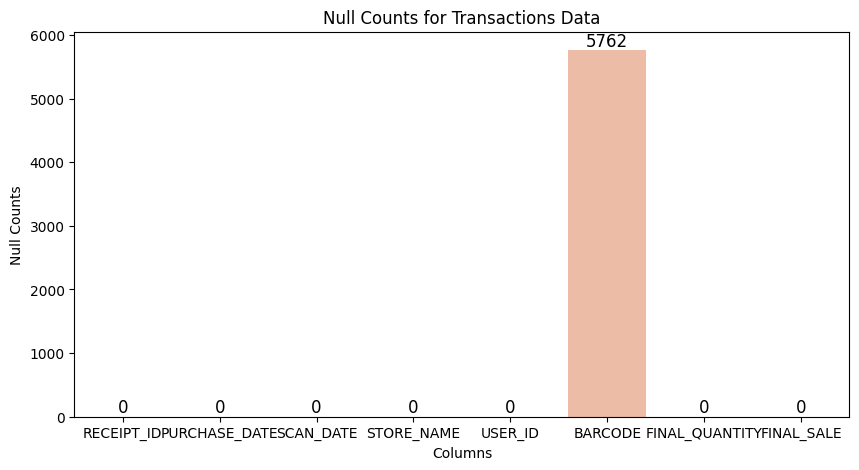

In [5]:
plt.figure(figsize=(10, 5))
ax_p = sns.barplot(
        x=p_null_counts.index,
        y=p_null_counts.values,
        palette="coolwarm"
    )

ax_p.bar_label(ax_p.containers[0], fmt="%.0f", fontsize=12, color="black")
plt.xlabel("Columns")
plt.ylabel("Null Counts")
plt.title("Null Counts for Product Data")
plt.show()

plt.figure(figsize=(10, 5))
ax_u = sns.barplot(
        x=u_null_counts.index,
        y=u_null_counts.values,
        palette="coolwarm"
    )

ax_u.bar_label(ax_u.containers[0], fmt="%.0f", fontsize=12, color="black")
plt.xlabel("Columns")
plt.ylabel("Null Counts")
plt.title("Null Counts for Users Data")
plt.show()

plt.figure(figsize=(10, 5))
ax_t = sns.barplot(
        x=t_null_counts.index,
        y=t_null_counts.values,
        palette="coolwarm"
    )

ax_t.bar_label(ax_t.containers[0], fmt="%.0f", fontsize=12, color="black")
plt.xlabel("Columns")
plt.ylabel("Null Counts")
plt.title("Null Counts for Transactions Data")
plt.show()

In [16]:
# Mismatch of data types within columns
condition = (transactions['FINAL_QUANTITY']=='zero')
print("numeric column with string value 'zero' record count: ",transactions[condition]['FINAL_SALE'].value_counts().sum())


numeric column with string value 'zero' record count:  12500


In [17]:
# Mismatch in data types within Final_sale
empty_sale = transactions['FINAL_SALE']==' '
print(transactions[empty_sale]['FINAL_QUANTITY'].value_counts().sum())


12500


#### Intresting Fact to note that the number of records with incorect data in columns FINAL_QUANTITY and FINAL_SALE are equal in number (12500) but are not the same record, leaving us with 25000 records which have incorect data

* Assuming to drop the records with null barcodes in Transactions as we cannot identify the relation between the transaction and the product details

In [18]:
# drop records which do not have barcodes
transactions = transactions.dropna(subset=['BARCODE'])
print(transactions.isnull().sum())

RECEIPT_ID        0
PURCHASE_DATE     0
SCAN_DATE         0
STORE_NAME        0
USER_ID           0
BARCODE           0
FINAL_QUANTITY    0
FINAL_SALE        0
dtype: int64


- Correcting the Incorrect values to make sure all the numeric data columns have only numeric data

In [19]:

transactions['FINAL_QUANTITY'] = transactions['FINAL_QUANTITY'].replace('zero','0.00').astype('float')
transactions['FINAL_SALE'] = transactions['FINAL_SALE'].replace(' ','0.00').astype('float')

> ### **Section 1**

### Top 5 brands by receipts scanned by users 21 and over

```sql
with temp as 
(
    SELECT
    brand,
    count(receipt_id) as c
    FROM (
        SELECT 
            t.receipt_id,
            p.brand,
        FROM TRANSACTIONS t
        JOIN PRODUCTS p ON t.barcode = p.barcode
        JOIN USERS u ON u.id = t.user_id
        WHERE t.barcode IS NOT NULL 
        AND u.birth_date IS NOT NULL 
        AND p.brand IS NOT NULL
        and datediff('year', birth_date, CURRENT_TIMESTAMP) >= 21
    ) subquery
    group by brand
)
select
    brand
from temp
order by c desc
limit 5;

```

```
BRAND
NERDS CANDY
DOVE
SOUR PATCH KIDS
COCA-COLA
TRIDENT
```

### What are the top 5 brands by sales among users that have had their account for at least six months

```sql
SELECT distinct
    brand,
    sum(final_sale::float) over(partition by brand) as sale
FROM TRANSACTIONS t
JOIN PRODUCTS p ON t.barcode = p.barcode
JOIN USERS u ON u.id = t.user_id
WHERE t.barcode IS NOT NULL 
  AND p.brand IS NOT NULL
  and datediff('month',u.created_date,current_timestamp) > 6
order by 2 desc
limit 5
;

```
```
BRAND
CVS
TRIDENT
DOVE
COORS LIGHT
QUAKER
```

> ### **Section 2**

### At what percent has Fetch grown year over year?

- considering only customer growth as the growth factor because we have sales only for one year(2024)

- assumptions
    1. Only user table is considered 
    2. assume that all the signed up users do not drop over time

```sql
with base as (
    select
        year(created_date) as year
        ,count(id) as total_customers
    from users
    group by 1
    order by 1
)
select
    *,
    round(
    coalesce(((total_customers - lag(total_customers) over(order by year ))/ lag(total_customers) over(order by year ))*100,0) , 1) as "Y-O-Y growth %"
from base
```
```
YEAR	TOTAL_CUSTOMERS	Y-O-Y growth %
2014	30	        0.0
2015	51	        70.0
2016	70	        37.3
2017	644	        820.0
2018	2168	        236.6
2019	7093	        227.2
2020	16883	        138.0
2021	19159	        13.5
2022	26807	        39.9
2023	15464	        -42.3
2024	11631	        -24.8
```

> ### Section 3

### Email message for business

Hi Team,

Analysing the dataset provided. I was able to come up with the following Observations.
1. The dataset by itself has a lot of Null values in the columns that are used to identify products and transactions forcing me to exclude all the records reducing the sample size by 10%.
2. The numeric columns used for calculating metrics have mix of data types leading us to lot of ambiguity while using data.
3. One Interesting finding was that the top 5 brands for our users were all related to daily consumer goods and medicine
4. Also another point to note is that the overall new customer enrollment has decreased over the past 2 years

I did have few requests to be made inorder to  pull better insights
1. If we can have the all the transactions over the last five years would be great to analyse the revenue growth
2. Emphasizing on validating the data type for each column must be put in place before inserting records into tables to avaid un-necessary data type conversions and incorrect data in columns
3. Adding column descriptions would really help in identifying specific columns based on business requirements .

Thanks and Regards